In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [3]:
sr = 44100
input_length = int(sr/2)
batch_size = 32


def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=sr)[0] 
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

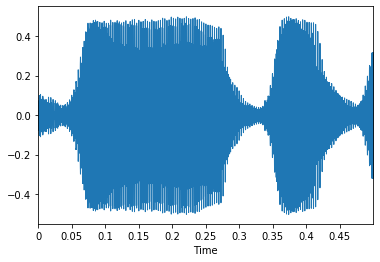

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=sr, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [6]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [7]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.sr = 44100
        self.input_length = int(sr/2)
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [8]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [9]:
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=32, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=32, shuffle=32)

# Model

In [19]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_256_3 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=True)
        self.conv1d_256_256_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_256_64 = nn.Linear(in_features=256, out_features=64)
        self.fc_64_1024 = nn.Linear(in_features=64, out_features=1024)
        self.fc_1024_42 = nn.Linear(in_features=1024, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_256_3(x)
        x = self.relu(x)
        x = self.conv1d_256_256_3(x)
        x = self.relu(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_256_64(x)
        x = self.relu(x)
        x = self.fc_64_1024(x)
        x = self.relu(x)
        x = self.fc_1024_42(x)
        x = self.softmax(x)
        
        return x

In [20]:
device

device(type='cuda')

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 22050))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 22044]             160
              ReLU-2            [-1, 16, 22044]               0
            Conv1d-3            [-1, 16, 22038]           2,320
              ReLU-4            [-1, 16, 22038]               0
         MaxPool1d-5             [-1, 16, 1377]               0
           Dropout-6             [-1, 16, 1377]               0
            Conv1d-7             [-1, 32, 1377]           1,568
              ReLU-8             [-1, 32, 1377]               0
            Conv1d-9             [-1, 32, 1377]           3,104
             ReLU-10             [-1, 32, 1377]               0
        MaxPool1d-11              [-1, 32, 344]               0
          Dropout-12              [-1, 32, 344]               0
           Conv1d-13              [-1, 32, 344]           3,104
             ReLU-14              [-1, 

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Model = FreeSound_Sense()
#Model.float()
#Model.to(device)

Model = FreeSound_Sense()
Model.load_state_dict(torch.load("FreeSound_1D_conv_global_pool_1013_epoch.stDict"))
Model.float()
Model.to(device)

FreeSound_Sense(
  (conv1d_1_16_9): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_16_9): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(True,))
  (conv1d_16_32_3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_32_3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_32_256_3): Conv1d(32, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (conv1d_256_256_3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(True,))
  (maxpool_16): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigm): Sigmoid()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_256_64): Linear(in_features=256, out_features=64, bias=True)
  (fc_64_1024): Linear(in_features=64, out_features=1024, bias=True)
  (fc_1024_42): Linear(in_features=1024, out_features=

In [46]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [47]:
epoch_progress_bar = tqdm.tqdm(range(0, 300))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*32)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*32)))


Epoch Loss:  3.407097357737867
Train Acc  37.038502109704645



Valid Acc  36.302083333333336



Epoch Loss:  3.4083959975826086
Train Acc  36.90664556962025



Valid Acc  35.46875



Epoch Loss:  3.412237904745818
Train Acc  36.52426160337553



Valid Acc  36.458333333333336



Epoch Loss:  3.4000144588293404
Train Acc  37.76371308016878



Valid Acc  35.520833333333336



Epoch Loss:  3.4030150240483668
Train Acc  37.39451476793249



Valid Acc  37.291666666666664



Epoch Loss:  3.4037574494438334
Train Acc  37.2626582278481



Valid Acc  36.25



Epoch Loss:  3.4011789907383014
Train Acc  37.5



Valid Acc  35.416666666666664



Epoch Loss:  3.407929523081719
Train Acc  36.86708860759494



Valid Acc  35.625



Epoch Loss:  3.399834547364762
Train Acc  37.76371308016878



Valid Acc  36.875



Epoch Loss:  3.40178757981409
Train Acc  37.61867088607595



Valid Acc  36.40625



Epoch Loss:  3.4028993950614446
Train Acc  37.447257383966246



Valid Acc  35.3125



Epoch Loss:  3.403626007369802
Train Acc  37.315400843881854



Valid Acc  36.302083333333336



Epoch Loss:  3.4104464778417274
Train Acc  36.73523206751055



Valid Acc  37.083333333333336



Epoch Loss:  3.4018811404956546
Train Acc  37.52637130801688



Valid Acc  37.5



Epoch Loss:  3.400586650341372
Train Acc  37.684599156118146



Valid Acc  36.5625



Epoch Loss:  3.3988101653408904
Train Acc  37.82964135021097



Valid Acc  36.458333333333336



Epoch Loss:  3.4110111204380726
Train Acc  36.550632911392405



Valid Acc  37.760416666666664



Epoch Loss:  3.4026462116321934
Train Acc  37.39451476793249



Valid Acc  37.708333333333336



Epoch Loss:  3.400548486266961
Train Acc  37.65822784810127



Valid Acc  37.395833333333336



Epoch Loss:  3.397959154869434
Train Acc  37.961497890295355



Valid Acc  35.9375



Epoch Loss:  3.401568377571267
Train Acc  37.631856540084385



Valid Acc  36.458333333333336



Epoch Loss:  3.3963463276247436
Train Acc  38.17246835443038



Valid Acc  37.708333333333336



Epoch Loss:  3.394460550340419
Train Acc  38.30432489451477



Valid Acc  36.71875



Epoch Loss:  3.405945894587392
Train Acc  37.17035864978903



Valid Acc  37.083333333333336



Epoch Loss:  3.400319139665692
Train Acc  37.684599156118146



Valid Acc  36.09375



Epoch Loss:  3.406393964582355
Train Acc  37.15717299578059



Valid Acc  36.09375



Epoch Loss:  3.4034598587937497
Train Acc  37.43407172995781



Valid Acc  36.40625



Epoch Loss:  3.400655825932821
Train Acc  37.57911392405063



Valid Acc  36.510416666666664



Epoch Loss:  3.4035278181486492
Train Acc  37.40770042194093



Valid Acc  35.572916666666664



Epoch Loss:  3.407601143237408
Train Acc  36.93301687763713



Valid Acc  36.770833333333336



Epoch Loss:  3.4020913623053315
Train Acc  37.42088607594937



Valid Acc  37.1875



Epoch Loss:  3.402293043297554
Train Acc  37.539556962025316



Valid Acc  36.510416666666664



Epoch Loss:  3.3990688535231577
Train Acc  37.89556962025316



Valid Acc  36.614583333333336



Epoch Loss:  3.3963362396014896
Train Acc  38.13291139240506



Valid Acc  37.447916666666664



Epoch Loss:  3.3975591629366333
Train Acc  37.961497890295355



Valid Acc  36.25



Epoch Loss:  3.4010144114997316
Train Acc  37.697784810126585



Valid Acc  36.458333333333336



Epoch Loss:  3.405591804769975
Train Acc  37.14398734177215



Valid Acc  37.65625



Epoch Loss:  3.4050958981493857
Train Acc  37.27584388185654



Valid Acc  36.25



Epoch Loss:  3.398366218880762
Train Acc  37.9087552742616



Valid Acc  36.5625



Epoch Loss:  3.398204342725408
Train Acc  37.85601265822785



Valid Acc  35.989583333333336



Epoch Loss:  3.401062296412665
Train Acc  37.56592827004219



Valid Acc  37.03125



Epoch Loss:  3.3987772424512777
Train Acc  37.93512658227848



Valid Acc  36.458333333333336



Epoch Loss:  3.395630051818075
Train Acc  38.15928270042194



Valid Acc  36.875



Epoch Loss:  3.397118825952715
Train Acc  38.04061181434599



Valid Acc  37.708333333333336



Epoch Loss:  3.3969357446276187
Train Acc  38.106540084388186



Valid Acc  35.989583333333336



Epoch Loss:  3.3973399114005174
Train Acc  38.014240506329116



Valid Acc  37.291666666666664



Epoch Loss:  3.3926747066562184
Train Acc  38.50210970464135



Valid Acc  36.927083333333336



Epoch Loss:  3.394856187361705
Train Acc  38.212025316455694



Valid Acc  37.552083333333336



Epoch Loss:  3.4000512185479015
Train Acc  37.81645569620253



Valid Acc  36.927083333333336



Epoch Loss:  3.401809770849687
Train Acc  37.52637130801688



Valid Acc  37.083333333333336



Epoch Loss:  3.3925764118065813
Train Acc  38.40981012658228



Valid Acc  35.052083333333336



Epoch Loss:  3.4010076512767293
Train Acc  37.56592827004219



Valid Acc  35.9375



Epoch Loss:  3.3959038026222195
Train Acc  38.17246835443038



Valid Acc  36.875



Epoch Loss:  3.395499623777494
Train Acc  38.09335443037975



Valid Acc  37.708333333333336



Epoch Loss:  3.396132462135347
Train Acc  38.09335443037975



Valid Acc  38.177083333333336



Epoch Loss:  3.3968391619654144
Train Acc  37.9746835443038



Valid Acc  36.40625



Epoch Loss:  3.392845513951426
Train Acc  38.47573839662447



Valid Acc  35.729166666666664



Epoch Loss:  3.3972976781144926
Train Acc  38.00105485232068



Valid Acc  34.84375



Epoch Loss:  3.4012072166813074
Train Acc  37.56592827004219



Valid Acc  35.885416666666664



Epoch Loss:  3.392934029615378
Train Acc  38.31751054852321



Valid Acc  36.875



Epoch Loss:  3.397339405389778
Train Acc  38.04061181434599



Valid Acc  36.666666666666664



Epoch Loss:  3.3994055739937954
Train Acc  37.84282700421941



Valid Acc  36.770833333333336



Epoch Loss:  3.391501134960963
Train Acc  38.541666666666664



Valid Acc  38.489583333333336



Epoch Loss:  3.400360839779367
Train Acc  37.65822784810127



Valid Acc  36.5625



Epoch Loss:  3.3942088638176897
Train Acc  38.34388185654009



Valid Acc  38.28125



Epoch Loss:  3.395713447015497
Train Acc  38.22521097046413



Valid Acc  37.708333333333336



Epoch Loss:  3.400949598867682
Train Acc  37.57911392405063



Valid Acc  36.71875



Epoch Loss:  3.4025816213229536
Train Acc  37.48681434599156



Valid Acc  37.916666666666664



Epoch Loss:  3.3976771569956203
Train Acc  37.89556962025316



Valid Acc  37.916666666666664



Epoch Loss:  3.3932104382333876
Train Acc  38.357067510548525



Valid Acc  36.927083333333336



Epoch Loss:  3.394697031391321
Train Acc  38.26476793248945



Valid Acc  37.65625



Epoch Loss:  3.40152384661421
Train Acc  37.51318565400844



Valid Acc  37.65625



Epoch Loss:  3.39989994346844
Train Acc  37.84282700421941



Valid Acc  38.177083333333336



Epoch Loss:  3.3946917238114755
Train Acc  38.31751054852321



Valid Acc  36.510416666666664



Epoch Loss:  3.3931724994997436
Train Acc  38.48892405063291



Valid Acc  37.34375



Epoch Loss:  3.395827861777841
Train Acc  38.05379746835443



Valid Acc  37.5



Epoch Loss:  3.396843836780339
Train Acc  37.94831223628692



Valid Acc  37.395833333333336



Epoch Loss:  3.3947295257310826
Train Acc  38.23839662447257



Valid Acc  36.927083333333336



Epoch Loss:  3.3955569971462847
Train Acc  38.15928270042194



Valid Acc  37.65625



Epoch Loss:  3.3882139916158427
Train Acc  38.98997890295359



Valid Acc  37.135416666666664



Epoch Loss:  3.3938993160231705
Train Acc  38.3834388185654



Valid Acc  37.1875



Epoch Loss:  3.3935890107215205
Train Acc  38.370253164556964



Valid Acc  37.708333333333336



Epoch Loss:  3.3984833890375707
Train Acc  37.882383966244724



Valid Acc  37.708333333333336



Epoch Loss:  3.394715326244821
Train Acc  38.34388185654009



Valid Acc  37.65625



Epoch Loss:  3.395519082556294
Train Acc  38.17246835443038



Valid Acc  36.458333333333336



Epoch Loss:  3.4053894457434803
Train Acc  37.10443037974684



Valid Acc  36.510416666666664



Epoch Loss:  3.396322204090875
Train Acc  38.014240506329116



Valid Acc  38.020833333333336



Epoch Loss:  3.3997356459058286
Train Acc  37.7373417721519



Valid Acc  36.510416666666664



Epoch Loss:  3.391878388602019
Train Acc  38.66033755274262



Valid Acc  36.302083333333336



Epoch Loss:  3.389990243227673
Train Acc  38.88449367088607



Valid Acc  36.875



Epoch Loss:  3.397649388776047
Train Acc  37.9087552742616



Valid Acc  37.447916666666664



Epoch Loss:  3.3947119048879117
Train Acc  38.30432489451477



Valid Acc  35.989583333333336



Epoch Loss:  3.3951509361025654
Train Acc  38.22521097046413



Valid Acc  36.510416666666664



Epoch Loss:  3.393295917832902
Train Acc  38.357067510548525



Valid Acc  37.96875



Epoch Loss:  3.3921028038620444
Train Acc  38.58122362869198



Valid Acc  37.447916666666664



Epoch Loss:  3.3889136123254833
Train Acc  38.84493670886076



Valid Acc  37.552083333333336



Epoch Loss:  3.3859108842374908
Train Acc  39.108649789029535



Valid Acc  38.333333333333336



Epoch Loss:  3.3909825976890855
Train Acc  38.72626582278481



Valid Acc  37.760416666666664



Epoch Loss:  3.3868748930436148
Train Acc  39.06909282700422



Valid Acc  38.125



Epoch Loss:  3.3968940867653377
Train Acc  37.961497890295355



Valid Acc  36.145833333333336



Epoch Loss:  3.394268677707463
Train Acc  38.33069620253165



Valid Acc  37.5



Epoch Loss:  3.392334324398121
Train Acc  38.48892405063291



Valid Acc  38.229166666666664



Epoch Loss:  3.3958311845481646
Train Acc  38.212025316455694



Valid Acc  37.395833333333336



Epoch Loss:  3.3945225995301196
Train Acc  38.34388185654009



Valid Acc  37.864583333333336



Epoch Loss:  3.3882927130043257
Train Acc  38.96360759493671



Valid Acc  37.65625



Epoch Loss:  3.389712670684364
Train Acc  38.765822784810126



Valid Acc  38.229166666666664



Epoch Loss:  3.3956804979702593
Train Acc  38.08016877637131



Valid Acc  37.03125



Epoch Loss:  3.393182144889349
Train Acc  38.370253164556964



Valid Acc  38.020833333333336



Epoch Loss:  3.393744461647066
Train Acc  38.370253164556964



Valid Acc  38.697916666666664



Epoch Loss:  3.3942130467056724
Train Acc  38.3834388185654



Valid Acc  37.916666666666664



Epoch Loss:  3.3849971485540333
Train Acc  39.266877637130804



Valid Acc  37.5



Epoch Loss:  3.389922143034794
Train Acc  38.71308016877637



Valid Acc  37.239583333333336



Epoch Loss:  3.397526262178703
Train Acc  38.05379746835443



Valid Acc  36.5625



Epoch Loss:  3.3873683470713942
Train Acc  38.97679324894515



Valid Acc  37.8125



Epoch Loss:  3.3941870590805503
Train Acc  38.50210970464135



Valid Acc  37.65625



Epoch Loss:  3.3947063951049676
Train Acc  38.23839662447257



Valid Acc  37.291666666666664



Epoch Loss:  3.392910838630129
Train Acc  38.47573839662447



Valid Acc  38.541666666666664



Epoch Loss:  3.387908152890105
Train Acc  38.95042194092827



Valid Acc  37.34375



Epoch Loss:  3.3901267534569848
Train Acc  38.779008438818565



Valid Acc  37.96875



Epoch Loss:  3.393575172384077
Train Acc  38.436181434599156



Valid Acc  37.447916666666664



Epoch Loss:  3.3905942822307473
Train Acc  38.73945147679325



Valid Acc  38.541666666666664



Epoch Loss:  3.387798316368071
Train Acc  38.91086497890296



Valid Acc  37.96875



Epoch Loss:  3.3905840272138894
Train Acc  38.67352320675106



Valid Acc  38.28125



Epoch Loss:  3.39353489071005
Train Acc  38.42299578059072



Valid Acc  38.229166666666664



Epoch Loss:  3.386700814283347
Train Acc  39.095464135021096



Valid Acc  38.854166666666664



Epoch Loss:  3.3880910984071497
Train Acc  38.89767932489451



Valid Acc  38.333333333333336



Epoch Loss:  3.388993276322441
Train Acc  38.83175105485232



Valid Acc  39.010416666666664



Epoch Loss:  3.3874753235764645
Train Acc  39.06909282700422



Valid Acc  37.708333333333336



Epoch Loss:  3.385648676111728
Train Acc  39.21413502109704



Valid Acc  37.135416666666664



Epoch Loss:  3.388353735082763
Train Acc  38.83175105485232



Valid Acc  37.291666666666664



Epoch Loss:  3.3848144062460728
Train Acc  39.17457805907173



Valid Acc  37.1875



Epoch Loss:  3.390775896828889
Train Acc  38.63396624472574



Valid Acc  36.614583333333336



Epoch Loss:  3.3931188170919944
Train Acc  38.40981012658228



Valid Acc  37.65625



Epoch Loss:  3.3866594843723603
Train Acc  39.029535864978904



Valid Acc  37.96875



Epoch Loss:  3.388796925041746
Train Acc  38.792194092827



Valid Acc  38.28125



Epoch Loss:  3.385054133612395
Train Acc  39.24050632911393



Valid Acc  38.4375



Epoch Loss:  3.3898266528729146
Train Acc  38.72626582278481



Valid Acc  38.333333333333336



Epoch Loss:  3.388569886171365
Train Acc  38.937236286919834



Valid Acc  36.25



Epoch Loss:  3.393308608340815
Train Acc  38.3834388185654



Valid Acc  37.760416666666664



Epoch Loss:  3.3922577608486773
Train Acc  38.51529535864979



Valid Acc  37.864583333333336



Epoch Loss:  3.390645790703689
Train Acc  38.67352320675106



Valid Acc  37.604166666666664



Epoch Loss:  3.3863316980595326
Train Acc  39.029535864978904



Valid Acc  37.604166666666664



Epoch Loss:  3.3892838612890444
Train Acc  38.792194092827



Valid Acc  39.114583333333336



Epoch Loss:  3.384407439815344
Train Acc  39.345991561181435



Valid Acc  37.916666666666664



Epoch Loss:  3.385004438931429
Train Acc  39.108649789029535



Valid Acc  39.322916666666664



Epoch Loss:  3.3884814922316666
Train Acc  38.95042194092827



Valid Acc  38.072916666666664



Epoch Loss:  3.3905338798394182
Train Acc  38.5548523206751



Valid Acc  37.34375



Epoch Loss:  3.3890127682987647
Train Acc  38.779008438818565



Valid Acc  36.927083333333336



Epoch Loss:  3.3931039526492737
Train Acc  38.357067510548525



Valid Acc  37.760416666666664



Epoch Loss:  3.3890917794110904
Train Acc  38.924050632911396



Valid Acc  37.760416666666664



Epoch Loss:  3.3961604536837164
Train Acc  38.1460970464135



Valid Acc  37.1875



Epoch Loss:  3.388908292673811
Train Acc  38.84493670886076



Valid Acc  38.333333333333336



Epoch Loss:  3.39101350558961
Train Acc  38.58122362869198



Valid Acc  36.5625



Epoch Loss:  3.388358172485094
Train Acc  38.88449367088607



Valid Acc  37.083333333333336



Epoch Loss:  3.39012748279652
Train Acc  38.75263713080169



Valid Acc  37.8125



Epoch Loss:  3.3930014095225918
Train Acc  38.357067510548525



Valid Acc  38.854166666666664



Epoch Loss:  3.390101902595552
Train Acc  38.686708860759495



Valid Acc  37.760416666666664



Epoch Loss:  3.385468636886983
Train Acc  39.200949367088604



Valid Acc  37.96875



Epoch Loss:  3.384289320008161
Train Acc  39.22732067510549



Valid Acc  37.760416666666664



Epoch Loss:  3.3845363508296917
Train Acc  39.24050632911393



Valid Acc  37.34375



Epoch Loss:  3.3880734715280654
Train Acc  38.81856540084388



Valid Acc  37.916666666666664



Epoch Loss:  3.3953644263593454
Train Acc  38.18565400843882



Valid Acc  38.072916666666664



Epoch Loss:  3.386204024407431
Train Acc  39.108649789029535



Valid Acc  37.083333333333336



Epoch Loss:  3.3916986501669584
Train Acc  38.594409282700425



Valid Acc  37.8125



Epoch Loss:  3.3940732801010842
Train Acc  38.27795358649789



Valid Acc  37.65625



Epoch Loss:  3.387221107000037
Train Acc  38.95042194092827



Valid Acc  37.708333333333336



Epoch Loss:  3.3851042809868663
Train Acc  39.187763713080166



Valid Acc  36.770833333333336



Epoch Loss:  3.391727935412765
Train Acc  38.6207805907173



Valid Acc  37.291666666666664



Epoch Loss:  3.387394122433562
Train Acc  39.04272151898734



Valid Acc  37.135416666666664



Epoch Loss:  3.3851781042316293
Train Acc  39.187763713080166



Valid Acc  38.385416666666664



Epoch Loss:  3.391883016135622
Train Acc  38.42299578059072



Valid Acc  37.916666666666664



Epoch Loss:  3.3879418121611518
Train Acc  38.91086497890296



Valid Acc  36.927083333333336



Epoch Loss:  3.386295111370489
Train Acc  39.13502109704641



Valid Acc  37.604166666666664



Epoch Loss:  3.3866963547493336
Train Acc  39.00316455696203



Valid Acc  38.645833333333336



Epoch Loss:  3.389277945087932
Train Acc  38.72626582278481



Valid Acc  38.333333333333336



Epoch Loss:  3.387867983886461
Train Acc  38.88449367088607



Valid Acc  36.927083333333336



Epoch Loss:  3.3857556023175204
Train Acc  39.14820675105485



Valid Acc  38.75



Epoch Loss:  3.390588856950591
Train Acc  38.594409282700425



Valid Acc  38.229166666666664



Epoch Loss:  3.388958197605761
Train Acc  38.91086497890296



Valid Acc  38.90625



Epoch Loss:  3.3896233130104934
Train Acc  38.779008438818565



Valid Acc  38.177083333333336



Epoch Loss:  3.383261231933465
Train Acc  39.30643459915612



Valid Acc  38.90625



Epoch Loss:  3.3904046680353863
Train Acc  38.686708860759495



Valid Acc  37.1875



Epoch Loss:  3.388394645497769
Train Acc  38.91086497890296



Valid Acc  38.541666666666664



Epoch Loss:  3.3944853609624293
Train Acc  38.30432489451477



Valid Acc  36.875



Epoch Loss:  3.3875586825584056
Train Acc  38.97679324894515



Valid Acc  38.90625



Epoch Loss:  3.3849544686104176
Train Acc  39.28006329113924



Valid Acc  38.958333333333336



Epoch Loss:  3.3877729031607067
Train Acc  39.00316455696203



Valid Acc  38.229166666666664



Epoch Loss:  3.3845197741995383
Train Acc  39.29324894514768



Valid Acc  39.791666666666664



Epoch Loss:  3.3825594634446414
Train Acc  39.47784810126582



Valid Acc  39.322916666666664



Epoch Loss:  3.387701867501947
Train Acc  38.858122362869196



Valid Acc  36.927083333333336



Epoch Loss:  3.3855020637753643
Train Acc  39.16139240506329



Valid Acc  37.8125



Epoch Loss:  3.3884323649265595
Train Acc  38.937236286919834



Valid Acc  39.114583333333336



Epoch Loss:  3.3855039540222425
Train Acc  39.095464135021096



Valid Acc  38.385416666666664



Epoch Loss:  3.387367038284173
Train Acc  38.97679324894515



Valid Acc  37.395833333333336



Epoch Loss:  3.382535356006542
Train Acc  39.517405063291136



Valid Acc  38.020833333333336



Epoch Loss:  3.382585709608054
Train Acc  39.55696202531646



Valid Acc  39.010416666666664



Epoch Loss:  3.3775386679524613
Train Acc  39.95253164556962



Valid Acc  39.479166666666664



Epoch Loss:  3.38369246072407
Train Acc  39.37236286919831



Valid Acc  37.1875



Epoch Loss:  3.386600301235537
Train Acc  39.00316455696203



Valid Acc  37.864583333333336



Epoch Loss:  3.38532460389761
Train Acc  39.22732067510549



Valid Acc  38.072916666666664



Epoch Loss:  3.384049695252366
Train Acc  39.30643459915612



Valid Acc  38.645833333333336



Epoch Loss:  3.388009214200048
Train Acc  38.858122362869196



Valid Acc  38.802083333333336



Epoch Loss:  3.386698592061232
Train Acc  39.029535864978904



Valid Acc  39.479166666666664



Epoch Loss:  3.387759691552271
Train Acc  39.016350210970465



Valid Acc  38.229166666666664



Epoch Loss:  3.385592943505396
Train Acc  39.108649789029535



Valid Acc  37.760416666666664



Epoch Loss:  3.381519130513638
Train Acc  39.64926160337553



Valid Acc  39.427083333333336



Epoch Loss:  3.3860398606409
Train Acc  38.98997890295359



Valid Acc  37.708333333333336



Epoch Loss:  3.388881003303367
Train Acc  38.779008438818565



Valid Acc  37.135416666666664



Epoch Loss:  3.385236016808683
Train Acc  39.21413502109704



Valid Acc  38.541666666666664



Epoch Loss:  3.383269626883012
Train Acc  39.425105485232066



Valid Acc  38.90625



Epoch Loss:  3.3862768074631187
Train Acc  39.187763713080166



Valid Acc  38.333333333333336



Epoch Loss:  3.3814748570888855
Train Acc  39.54377637130802



Valid Acc  38.4375



Epoch Loss:  3.3832154998296424
Train Acc  39.49103375527426



Valid Acc  37.864583333333336



Epoch Loss:  3.381894410411014
Train Acc  39.55696202531646



Valid Acc  38.541666666666664



Epoch Loss:  3.380140922240567
Train Acc  39.78111814345991



Valid Acc  39.791666666666664



Epoch Loss:  3.377086293345262
Train Acc  40.04483122362869



Valid Acc  37.604166666666664



Epoch Loss:  3.381260153613513
Train Acc  39.78111814345991



Valid Acc  38.020833333333336



Epoch Loss:  3.3860902373800803
Train Acc  39.14820675105485



Valid Acc  37.083333333333336



Epoch Loss:  3.3853805306591567
Train Acc  39.12183544303797



Valid Acc  38.90625



Epoch Loss:  3.385376842716072
Train Acc  39.21413502109704



Valid Acc  38.802083333333336



Epoch Loss:  3.389054979453107
Train Acc  38.81856540084388



Valid Acc  40.052083333333336



Epoch Loss:  3.3891865442573774
Train Acc  38.89767932489451



Valid Acc  37.552083333333336



Epoch Loss:  3.3866303188388356
Train Acc  39.14820675105485



Valid Acc  37.5



Epoch Loss:  3.3865005819103384
Train Acc  39.200949367088604



Valid Acc  39.21875



Epoch Loss:  3.384928968888295
Train Acc  39.24050632911393



Valid Acc  38.4375



Epoch Loss:  3.386970215205905
Train Acc  39.12183544303797



Valid Acc  39.166666666666664



Epoch Loss:  3.382341661533726
Train Acc  39.5042194092827



Valid Acc  38.333333333333336



Epoch Loss:  3.381291515213528
Train Acc  39.517405063291136



Valid Acc  38.489583333333336



Epoch Loss:  3.3884306799007367
Train Acc  39.05590717299578



Valid Acc  39.791666666666664



Epoch Loss:  3.3830906630568363
Train Acc  39.39873417721519



Valid Acc  39.375



Epoch Loss:  3.3813205549988568
Train Acc  39.5042194092827



Valid Acc  39.010416666666664



Epoch Loss:  3.384082210717825
Train Acc  39.266877637130804



Valid Acc  38.541666666666664



Epoch Loss:  3.3788696995264367
Train Acc  39.95253164556962



Valid Acc  37.916666666666664



Epoch Loss:  3.3865047899479603
Train Acc  39.08227848101266



Valid Acc  40.052083333333336



Epoch Loss:  3.3804636424100853
Train Acc  39.66244725738397



Valid Acc  38.4375



Epoch Loss:  3.386663565655801
Train Acc  39.04272151898734



Valid Acc  38.28125



Epoch Loss:  3.382576758348489
Train Acc  39.39873417721519



Valid Acc  37.708333333333336



Epoch Loss:  3.3872259820060893
Train Acc  38.98997890295359



Valid Acc  38.229166666666664



Epoch Loss:  3.3877058381269753
Train Acc  38.792194092827



Valid Acc  38.90625



Epoch Loss:  3.384087002227075
Train Acc  39.37236286919831



Valid Acc  38.645833333333336



Epoch Loss:  3.386565381464576
Train Acc  39.029535864978904



Valid Acc  38.177083333333336



Epoch Loss:  3.383007120985522
Train Acc  39.47784810126582



Valid Acc  39.114583333333336



Epoch Loss:  3.3850780096738147
Train Acc  39.187763713080166



Valid Acc  38.4375



Epoch Loss:  3.38840739535883
Train Acc  38.88449367088607



Valid Acc  38.385416666666664



Epoch Loss:  3.385762844407609
Train Acc  39.108649789029535



Valid Acc  37.34375



Epoch Loss:  3.383596568167964
Train Acc  39.24050632911393



Valid Acc  38.697916666666664



Epoch Loss:  3.3814249360611672
Train Acc  39.517405063291136



Valid Acc  38.90625



Epoch Loss:  3.3813851161345148
Train Acc  39.675632911392405



Valid Acc  38.59375



Epoch Loss:  3.379429905726437
Train Acc  39.83386075949367



Valid Acc  38.489583333333336



Epoch Loss:  3.3786166730309337
Train Acc  39.89978902953587



Valid Acc  39.010416666666664



Epoch Loss:  3.3812576376436128
Train Acc  39.64926160337553



Valid Acc  38.59375



Epoch Loss:  3.385999122249426
Train Acc  39.04272151898734



Valid Acc  38.489583333333336



Epoch Loss:  3.3804827993932154
Train Acc  39.7415611814346



Valid Acc  37.96875



Epoch Loss:  3.378158166941711
Train Acc  39.89978902953587



Valid Acc  39.322916666666664



Epoch Loss:  3.3815199252422348
Train Acc  39.60970464135021



Valid Acc  38.854166666666664



Epoch Loss:  3.381325929979735
Train Acc  39.583333333333336



Valid Acc  37.291666666666664



Epoch Loss:  3.3778389657097025
Train Acc  39.93934599156118



Valid Acc  39.895833333333336



Epoch Loss:  3.376717091612675
Train Acc  39.9789029535865



Valid Acc  39.010416666666664



Epoch Loss:  3.3770161027143777
Train Acc  39.93934599156118



Valid Acc  39.166666666666664



Epoch Loss:  3.384922067827313
Train Acc  39.187763713080166



Valid Acc  38.854166666666664



Epoch Loss:  3.3794589968170294
Train Acc  39.72837552742616



Valid Acc  40.104166666666664



Epoch Loss:  3.381658886052385
Train Acc  39.60970464135021



Valid Acc  39.84375



Epoch Loss:  3.3851143297766835
Train Acc  39.22732067510549



Valid Acc  37.552083333333336



Epoch Loss:  3.3855539132774126
Train Acc  39.24050632911393



Valid Acc  39.0625



Epoch Loss:  3.382483724803361
Train Acc  39.438291139240505



Valid Acc  39.322916666666664



Epoch Loss:  3.382735187997295
Train Acc  39.438291139240505



Valid Acc  38.90625



Epoch Loss:  3.379264897938016
Train Acc  39.80748945147679



Valid Acc  39.427083333333336



Epoch Loss:  3.3775900235155967
Train Acc  40.018459915611814



Valid Acc  40.052083333333336



Epoch Loss:  3.381309293996433
Train Acc  39.64926160337553



Valid Acc  39.322916666666664



Epoch Loss:  3.3803688896356254
Train Acc  39.754746835443036



Valid Acc  38.697916666666664



Epoch Loss:  3.374761081446072
Train Acc  40.37447257383966



Valid Acc  39.114583333333336



Epoch Loss:  3.3785332788394977
Train Acc  39.95253164556962



Valid Acc  38.333333333333336



Epoch Loss:  3.3768750756098753
Train Acc  40.097573839662445



Valid Acc  39.895833333333336



Epoch Loss:  3.380930758729766
Train Acc  39.5701476793249



Valid Acc  37.395833333333336



Epoch Loss:  3.3829162523213316
Train Acc  39.46466244725738



Valid Acc  38.90625



Epoch Loss:  3.384260197732016
Train Acc  39.46466244725738



Valid Acc  38.59375



Epoch Loss:  3.379075610687964
Train Acc  39.93934599156118



Valid Acc  39.270833333333336



Epoch Loss:  3.382371006132681
Train Acc  39.530590717299575



Valid Acc  39.583333333333336



Epoch Loss:  3.3780657168682113
Train Acc  39.93934599156118



Valid Acc  38.385416666666664



Epoch Loss:  3.3834629260035003
Train Acc  39.38554852320675



Valid Acc  38.541666666666664



Epoch Loss:  3.3883991784687284
Train Acc  38.84493670886076



Valid Acc  39.6875



Epoch Loss:  3.385780488388448
Train Acc  39.16139240506329



Valid Acc  38.958333333333336



Epoch Loss:  3.380681637470229
Train Acc  39.60970464135021



Valid Acc  38.90625



Epoch Loss:  3.3792272539581427
Train Acc  39.86023206751055



Valid Acc  39.010416666666664



Epoch Loss:  3.378150811175254
Train Acc  40.018459915611814



Valid Acc  39.791666666666664



Epoch Loss:  3.3784426184143195
Train Acc  39.80748945147679



Valid Acc  39.6875



Epoch Loss:  3.382616732190933
Train Acc  39.45147679324894



Valid Acc  38.802083333333336



Epoch Loss:  3.378999333844406
Train Acc  39.7415611814346



Valid Acc  38.125



Epoch Loss:  3.3778860066007463
Train Acc  40.03164556962025



Valid Acc  38.4375



Epoch Loss:  3.37579288764342
Train Acc  40.097573839662445



Valid Acc  38.333333333333336



Epoch Loss:  3.378892611853684
Train Acc  39.72837552742616



Valid Acc  39.270833333333336



Epoch Loss:  3.3773715747559625
Train Acc  39.96571729957806



Valid Acc  38.697916666666664



Epoch Loss:  3.3782681624094644
Train Acc  39.88660337552743



Valid Acc  39.322916666666664



Epoch Loss:  3.381736059229082
Train Acc  39.55696202531646



Valid Acc  37.96875



Epoch Loss:  3.3798145422955606
Train Acc  39.688818565400844



Valid Acc  38.854166666666664



Epoch Loss:  3.3841800438200873
Train Acc  39.22732067510549



Valid Acc  39.010416666666664



Epoch Loss:  3.380704097103972
Train Acc  39.767932489451475



Valid Acc  38.802083333333336



Epoch Loss:  3.3862969704318147
Train Acc  39.04272151898734



Valid Acc  39.270833333333336



Epoch Loss:  3.375835626940184
Train Acc  40.17668776371308



Valid Acc  39.21875



Epoch Loss:  3.3753174306974127
Train Acc  40.17668776371308



Valid Acc  39.270833333333336



In [42]:
torch.save(Model.state_dict(), "FreeSound_1D_conv_global_pool_1313_epoch.stDict")

In [43]:
i=0
for data in FreeSoundDataLoader:
    if i==4:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.40625 13


[(tensor(36), True),
 (tensor(22), False),
 (tensor(27), False),
 (tensor(40), False),
 (tensor(1), False),
 (tensor(37), False),
 (tensor(25), True),
 (tensor(6), True),
 (tensor(25), False),
 (tensor(34), False),
 (tensor(10), False),
 (tensor(8), True),
 (tensor(11), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(3), True),
 (tensor(10), True),
 (tensor(23), False),
 (tensor(39), False),
 (tensor(10), True),
 (tensor(30), True),
 (tensor(36), False),
 (tensor(17), False),
 (tensor(30), True),
 (tensor(12), True),
 (tensor(39), True),
 (tensor(18), False),
 (tensor(5), False),
 (tensor(30), True),
 (tensor(8), False),
 (tensor(4), False),
 (tensor(30), False)]